# CSE 6240: Assignment 1
## Name: Anurag Roy (aroy74)



### 1: Processing text to create design matrices

Importing essential libraries and datasets below

In [1]:
import pandas as pd
from bs4 import BeautifulSoup             
import re
import nltk
from nltk.corpus import stopwords # Import the stop word list
import numpy as np
from datetime import datetime

train = pd.read_csv("labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
test  = pd.read_csv("testData.tsv", header=0, delimiter="\t", quoting=3)





Recreating Kaggle approach:    
    
    
    
    



In [4]:
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, "html.parser").get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))   
    


num_reviews = train["review"].size

clean_train_reviews = []
clean_test_reviews = []

for i in range( 0, num_reviews ):
    # Call our function for each one, and add the result to the list of
    # clean reviews
    clean_train_reviews.append( review_to_words( train["review"][i] ) )
    clean_test_reviews.append( review_to_words( test["review"][i] ) )


from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 
                             


Creating design matrices for training data:

In [3]:

print ("Creating design matrix X_counts \n")

X_counts = vectorizer.fit_transform(clean_train_reviews)

X_counts = X_counts.toarray()

vocab = vectorizer.get_feature_names()

dist = np.sum(X_counts, axis=0)


print ("Creating design matrix X_binary by copying X_counts, and then assigning all nonzeroes to 1 \n")
X_binary = np.copy(X_counts)

X_binary[X_binary>0] = 1 

print ("Creating design matrix X_tfidf \n")
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
X_tfidf = transformer.fit_transform(X_counts).toarray()

print ("Creating design matrix X_binary_imbalance \n ")

import random
random.seed(0)
#Row indexes for sentiment = 1 reviews
train_sent1 = train[train["sentiment"]==1].index.tolist()
train_sent1 = random.sample(train_sent1, int(len(train_sent1)*0.25))

imbalance_idx = train_sent1 + train[train["sentiment"]==0].index.tolist()

imbalance_idx.sort()

X_binary_imbalance = np.copy(X_counts[imbalance_idx])




print ("Completed...\n")







Creating design matrix X_counts 

Creating design matrix X_binary by copying X_counts, and then assigning all nonzeroes to 1 

Creating design matrix X_tfidf 

Creating design matrix X_binary_imbalance 
 
Completed...



Creating design matrices for test data

In [222]:
print ("Creating design matrix X_counts2 \n")

X_counts2 = vectorizer.fit_transform(clean_test_reviews)

X_counts2 = X_counts2.toarray()



print ("Creating design matrix X_binary2 by copying X_counts2, and then assigning all nonzeroes to 1 \n")

X_binary2 = np.copy(X_counts2)

X_binary2[X_binary2>0] = 1 

print ("Creating design matrix X_tfidf2 \n")
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)

X_tfidf2 = transformer.fit_transform(X_counts2).toarray()


print ("Completed...\n")





Creating design matrix X_counts2 

Creating design matrix X_binary2 by copying X_counts2, and then assigning all nonzeroes to 1 

Creating design matrix X_tfidf2 

Completed...



### 2: Feature space similarity experiment

Function to return the Euclidean distance between rows i and j of a design matrix

In [ ]:
def dist(X, i, j, distance_function='Euclidean'):
    if distance_function == 'Euclidean':
        return np.linalg.norm(X[i] - X[j])


Function to return closest k rows from a design matrix:

In [5]:
from sklearn.metrics.pairwise import pairwise_distances
def topk(X, k):
    #print ("Distance Matrix build starting... \n") 
    distance_matrix = pairwise_distances(X, metric = 'euclidean', n_jobs = 1) #Compute distance matrix
    #print ("Distance Matrix built \n") 
    
    vals = distance_matrix[np.nonzero(distance_matrix)].flatten()
    #print ("Flattened distance matrix... \n")
    vals = sorted(list(set(vals)))[:k]
    #print ("obtained k minimum distances")
    
    #print ("Actual distance values obtained from distance matrix") 
    
    output = [] 
 
    unique, counts =  np.unique(vals, return_counts=True)
        
    counter = dict(zip(unique, counts))
    
    #print ("Starting search for values: \n") 
    
    for val in vals:
        for i in range(counter[val]):
            position = np.column_stack(np.where(np.triu (distance_matrix, k=1) == val))[i]                        
            j = position[0]
            k =position[1]
            output.append((j, k , val, train["review"][j][:20], train["review"][k][:20]))
            output = sorted(list(set(output)), key = lambda x: x[2]) 
            
    
    return output
    

Function to compare reviews of the top-k outputs   

In [12]:
def review_comparison(k):
    print ("Starting topk processing \n")
    X_counts_out = topk(X_counts, k)
    print ("X_counts topk complete")
    X_binary_out = topk(X_binary, k)
    print ("X_binary topk complete")
    X_binary_imbalance_out = topk(X_binary_imbalance, k)
    print ("X_binary_imbalance topk complete")
    X_tfidf_out = topk(X_tfidf, k)
    print ("X_tfidf topk complete")
    
    for i in range(k):
        print ("X_counts reviews: {}\n {} \n \n".format(X_counts_out[i][3], X_counts_out[i][4] ))
        print ("X_binary reviews: {}\n {} \n \n".format(X_binary_out[i][3], X_binary_out[i][4] ))
        print ("X_binary_imbalance reviews: {}\n {} \n \n".format(X_binary_imbalance_out[i][3], X_binary_imbalance_out[i][4] ))
        print ("X_tfidf reviews: {}\n {} \n \n".format(X_tfidf_out[i][3], X_tfidf_out[i][4] ))
        
    

In [ ]:
review_comparison(3)

Starting topk processing 

X_counts topk complete
X_binary topk complete
X_binary_imbalance topk complete


### 3: Classification experiment:

The function $classify$ takes a design matrix and its corresponding response (sentiment value) to find an optimal C value for an SVC that maximizes roc_auc score (using 80% of the data). On obtaining this optimal C value, the model is retrained on the entire data to obtain metrics for false positive rate, true positive rate, and AUC ROC value. 

In [235]:
from sklearn.model_selection import train_test_split
random_state = np.random.RandomState(0)
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

def classify (X,y):   
    
    if isinstance(y , pd.Series):
        y = np.array(y.tolist())
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)
    
    output = []
    
    C = np.random.uniform( -4, 4, size = 30) #Creating a randomized grid of 30 C values (using logs of 1e-4 and 1e4)
        
    for val in C: #looping through the 30 C values to 
        clf = svm.LinearSVC(C = val)
        avg_score = np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc'))
        output.append((avg_score, val))
    
    roc_lift = max(output, key = lambda x: x[0])[0] - min(output, key = lambda x: x[0])[0]  #Calulating the lift in AUC-ROC obtained by the best and worst performing C value
    
    C_final = max(output, key = lambda x: x[0])[1] #best C value
    
    final_clf = svm.LinearSVC(C = C_final) #Retraining the classifier using the best C value
    
    y_score = final_clf.fit(X_train, y_train).decision_function(X_test) #Using decision_function to obtain probability
    
    fpr, tpr, _ = roc_curve (y_test, y_score) #extracting false positive rate and true positive rate
    
    roc_auc = auc(fpr, tpr) #final AUC ROC value
    
    return C_final, roc_lift, (fpr, tpr, roc_auc)
    
    

In [183]:
#Extracting best C value, lift amounts and ROC metrics for the 4 design matrices

X_counts_C, X_counts_lift, X_counts_roc = classify(X_counts, train["sentiment"])


X_tfidf_C, X_tfidf_lift,X_tfidf_roc = classify(X_tfidf, train["sentiment"])


X_bin_imb_C, X_bin_imb_lift, X_bin_imb_roc = classify(X_binary_imbalance,train["sentiment"][imbalance_idx])



X_binary_C, X_binary_lift, X_binary_roc = classify(X_binary, train["sentiment"])




In [211]:
print ( 'X_counts: The best value of C is {} and its AUC-ROC lift is {} '.format(X_counts_C, X_counts_lift) )
print ( "X_tfidf: The best value of C is {} and its AUC-ROC lift is{}".format(X_tfidf_C, X_tfidf_lift) )
print ( "X_binary_imbalance: The best value of C is {} and its AUC-ROC lift is {} ".format( X_bin_imb_C, X_bin_imb_lift))
print ( "X_binary: The best value of C is {} and its AUC-ROC lift is {} ".format( X_binary_C, X_binary_lift))



X_counts: The best value of C is 27.41713267842546 and its AUC-ROC lift is 0.00043992747720800196 
X_tfidf: The best value of C is 296.3254751248787 and its AUC-ROC lift is0.0010791590920985472
X_binary_imbalance: The best value of C is 52.23445994679861 and its AUC-ROC lift is 8.953219953689029e-05 
X_binary: The best value of C is 585.7483544919298 and its AUC-ROC lift is 0.00022835248289043708 


#### Kaggle submissions




In [219]:
#X_counts 
clf = svm.LinearSVC(C =X_counts_C )
y_score = clf.fit(X_counts, np.array(train["sentiment"].tolist())).predict(X_counts2)
df = pd.DataFrame(data = {"id": test["id"], "sentiment": y_score})
df.to_csv("sampleSubmission.csv", quoting = 3, index = False)



In [223]:
#X_binary
clf2 = svm.LinearSVC(C = X_binary_C)
y_score2 = clf.fit(X_binary, np.array(train["sentiment"].tolist())).predict(X_binary2)
df = pd.DataFrame(data = {"id": test["id"], "sentiment": y_score2})
df.to_csv("sampleSubmission.csv", quoting = 3, index = False)



In [227]:
#X_binary_imbalance
clf3 = svm.LinearSVC(C = X_bin_imb_C)
y_score3 = clf.fit(X_binary_imbalance, np.array(train["sentiment"][imbalance_idx].tolist())).predict(X_binary2)
df = pd.DataFrame(data = {"id": test["id"], "sentiment": y_score3})
df.to_csv("sampleSubmission.csv", quoting = 3, index = False)



In [229]:
#X_tfidf
clf4 = svm.LinearSVC(C = X_tfidf_C)
y_score4 = clf.fit(X_tfidf, np.array(train["sentiment"].tolist())).predict(X_tfidf2)
df = pd.DataFrame(data = {"id": test["id"], "sentiment": y_score4})
df.to_csv("sampleSubmission.csv", quoting = 3, index = False)



In [231]:

kaggle_score_X_counts = 0.52284
kaggle_score_X_binary = 0.51652
kaggle_score_X_binary_imbalance =0.54284
kaggle_score_X_tfidf = 0.54872

#### ROC Plots
Using the ROC metrics obtained from each design matrix, we will now create a function to plot ROC curves for each design matrix.

In [200]:
import matplotlib.pyplot as plt

def ROC_plotter(X, roc_metrics, name = None):
    fpr, tpr, roc_auc = roc_metrics
    plt.plot(fpr,tpr, lw = 2, color='darkorange', label='AUC = %0.2f' % roc_auc)
    #plt.plot(fpr,tpr, lw = 2, color='darkorange', label='AUCxsd = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('ROC for %s' %(name))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")    
    plt.show()

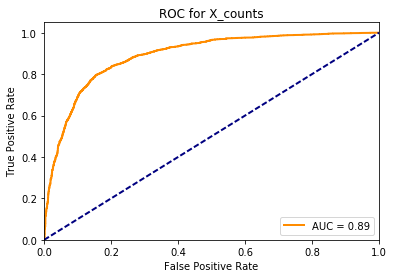

In [236]:
ROC_plotter(X_counts,X_counts_roc, "X_counts")

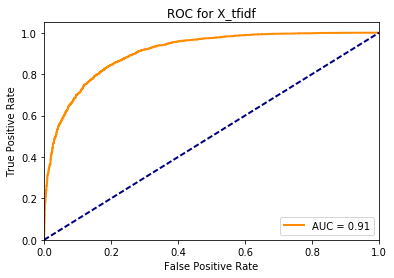

In [192]:
ROC_plotter(X_tfidf,X_tfidf_roc, "X_tfidf")

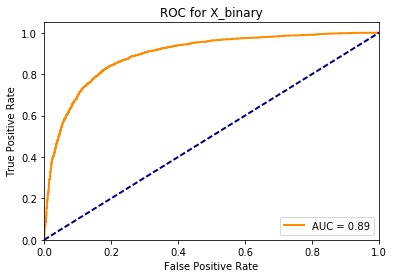

In [193]:
ROC_plotter(X_binary,X_binary_roc, "X_binary")

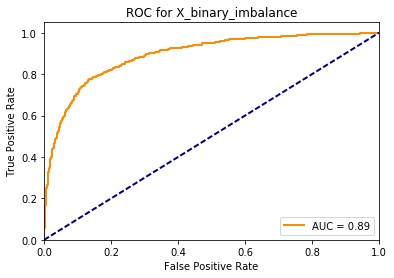

In [194]:
ROC_plotter(X_binary_imbalance,X_bin_imb_roc, "X_binary_imbalance")

## 4: Learning Curve Experiment

In [241]:

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
n_range = np.array((100, 500, 1000, 2000,3000, 4000, 5000, 7500, 10000, 15000, 20000))

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5, n_jobs=1, train_sizes= n_range):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


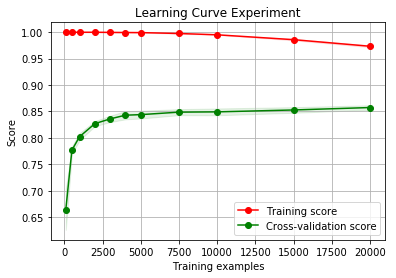

In [243]:
from sklearn.linear_model import LogisticRegression
estimator = LogisticRegression()
plot_learning_curve(estimator, title = "Learning Curve Experiment", X= X_counts, y = np.array(train["sentiment"].tolist()))
plt.show()

The learning curve tells us that the training score and cross validation score are converging as the number of training samples are increased, which lines up with our intuition.